This notebook demonstrates:
    
- How the mesh of Japanese GIS data are defined
- How to plot GIS information in an interactive map
- How to plot GIS information in a static map

# Library

We recommend anaconda/miniconda for setting up all dependencies:

```bash
$ conda install -c conda-forge jupyter geopandas shapely decartes matplotlib pip requests pillow chardet mpllealet && \
  pip install tilemapbase
```

# Download mesh data

Mesh data are provided in the e-stat page.  You can either
- Download from this [link](https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=Q&code=5339&coordSys=1&format=shape&downloadType=5) directly; or
- Go to the [e-Stat GIS page](https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=Q&coordsys=1&format=shape) and download the Shape file for `M5339`. 

Extract zip file in the same directory as this notebook.  Folder structure will be like:

```bash
.
├── mesh-mplleaflet-tilemapbase.ipynb
└── QDDSWQ5339
    ├── MESH05339.dbf
    ├── MESH05339.prj
    ├── MESH05339.shp
    └── MESH05339.shx
```

# Quick overview of the Mesh

In [1]:
import geopandas as gpd

x = gpd.read_file("QDDSWQ5339/MESH05339.shp")
print(x.shape)
x.head()

(100800, 8)


KEY_CODE MESH1_ID MESH2_ID MESH3_ID MESH4_ID MESH5_ID  OBJ_ID  \
0  5339000011     5339       00       00        1        1       1   
1  5339000012     5339       00       00        1        2       2   
2  5339000013     5339       00       00        1        3       3   
3  5339000014     5339       00       00        1        4       4   
4  5339000021     5339       00       00        2        1       5   

                                            geometry  
0  POLYGON ((139.00312 35.33333, 139.00000 35.333...  
1  POLYGON ((139.00625 35.33333, 139.00312 35.333...  
2  POLYGON ((139.00312 35.33542, 139.00000 35.335...  
3  POLYGON ((139.00625 35.33542, 139.00312 35.335...  
4  POLYGON ((139.00937 35.33333, 139.00625 35.333...

- `KEY_CODE` show the full mesh code for this shape
- `MESHX_ID` columns indicate the ID of different level. `KEY_CODE` is the concatenation of these columns.
- `OBJ_ID` is the row id.
- `geometry` is given as a polygon object.

## Mesh levels

Reference: [標準メッシュの体系とコード](https://www.gikosha.co.jp/fig_blog/mesh.html)

- 1st
  - 4 digit code, e.g. `5339`
  - 80km edge
- 2nd
  - 2 additional digits, e.g. `5339-23`
  - 10km edge (Split 1st to 8x8 cells)
- 3rd
  - 2 additional digits, e.g. `5339-23-43`
  - 1km edge (Split 1st to 10x10 cells) 
- 4th
  - 1 additinal digit, e.g. `5339-23-43-1`
  - 500m edge (Split 1st to 2x2 cells)
- 5th
  - 1 additional digit, e.g. `5339-23-43-1-2`
  - 250m edge (Split 1st to 2x2 cells)

# Plot mesh areas on interactive map

Since mesh areas are polygons, we can use `plot_polygon_collection` function to plot them.

Since plotting all 100K mesh areas will memory consuming, we will plot aggreagated mesh areas.
Geometries can be aggregated by using `geopanda`'s `disolve` meshod.

In [2]:
def aggregate_mesh(x, level):
    tmp = x.copy()
    code_len = [4, 6, 8, 9, 10][level-1]
    tmp["key"] = tmp["KEY_CODE"].str.slice(0, code_len)
    tmp = tmp[["key", "geometry"]]
    tmp = tmp.dissolve(by="key")
    return tmp

# aggregate to mesh level 1
mesh1 = aggregate_mesh(x, 1)
mesh1

geometry
key                                                    
5339  POLYGON ((139.29062 35.33333, 139.28750 35.333...

`plot_polygon_collection` function plots a series of geometries.  
But it does not tell where they are on the map.

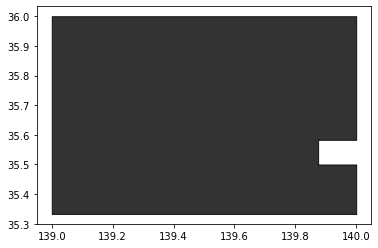

In [3]:
from geopandas.plotting import plot_polygon_collection
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plot_polygon_collection(ax, mesh1.geometry, edgecolor="#121212", facecolor="#333333")

`mplleaflet` transports the plot on to an interactive map.

In [4]:
import mplleaflet

mplleaflet.display(fig)

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [5]:
# aggregate to mesh level 2
mesh2 = aggregate_mesh(x, 2)
display(mesh2)

fig, ax = plt.subplots()
plot_polygon_collection(ax, mesh2.geometry, edgecolor="#121212", facecolor="#333333")
mplleaflet.display(fig)

geometry
key                                                      
533900  POLYGON ((139.11562 35.33333, 139.11250 35.333...
533901  POLYGON ((139.24062 35.33333, 139.23750 35.333...
533902  POLYGON ((139.36562 35.33333, 139.36250 35.333...
533903  POLYGON ((139.49062 35.33333, 139.48750 35.333...
533904  POLYGON ((139.61562 35.33333, 139.61250 35.333...
...                                                   ...
533973  POLYGON ((139.49062 35.91667, 139.48750 35.916...
533974  POLYGON ((139.61562 35.91667, 139.61250 35.916...
533975  POLYGON ((139.74062 35.91667, 139.73750 35.916...
533976  POLYGON ((139.86562 35.91667, 139.86250 35.916...
533977  POLYGON ((139.99062 35.91667, 139.98750 35.916...

[63 rows x 1 columns]

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


For mesh level 3, we will focus on to the mesh `5339-45`.  Our office is at the south-east corner of this mesh.  Unfortunately, it is only partially covered by this area since it is on the edge.

In [6]:
# aggregate to mesh level 3
mesh3 = aggregate_mesh(x[x.MESH2_ID == "45"], 3)
display(mesh3)

fig, ax = plt.subplots()
plot_polygon_collection(ax, mesh3.geometry, edgecolor="#121212", facecolor="#333333")
mplleaflet.display(fig)

geometry
key                                                        
53394500  POLYGON ((139.62812 35.66667, 139.62500 35.666...
53394501  POLYGON ((139.64062 35.66667, 139.63750 35.666...
53394502  POLYGON ((139.65312 35.66667, 139.65000 35.666...
53394503  POLYGON ((139.66562 35.66667, 139.66250 35.666...
53394504  POLYGON ((139.67812 35.66667, 139.67500 35.666...
...                                                     ...
53394595  POLYGON ((139.69062 35.74167, 139.68750 35.741...
53394596  POLYGON ((139.70312 35.74167, 139.70000 35.741...
53394597  POLYGON ((139.71562 35.74167, 139.71250 35.741...
53394598  POLYGON ((139.72812 35.74167, 139.72500 35.741...
53394599  POLYGON ((139.74062 35.74167, 139.73750 35.741...

[100 rows x 1 columns]

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [7]:
# aggregate to mesh level 4
mesh4 = aggregate_mesh(x[(x.MESH2_ID == "45") & (x.MESH3_ID == "09")], 4)
display(mesh4)

fig, ax = plt.subplots()
plot_polygon_collection(ax, mesh4.geometry, edgecolor="#121212", facecolor="#333333")
mplleaflet.display(fig)

geometry
key                                                         
533945091  POLYGON ((139.74062 35.66667, 139.73750 35.666...
533945092  POLYGON ((139.74687 35.66667, 139.74375 35.666...
533945093  POLYGON ((139.74062 35.67083, 139.73750 35.670...
533945094  POLYGON ((139.74687 35.67083, 139.74375 35.670...

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [8]:
# aggregate to mesh level 5
mesh5 = aggregate_mesh(x[(x.MESH2_ID == "45") & (x.MESH3_ID == "09")], 5)
display(mesh4)

fig, ax = plt.subplots()
plot_polygon_collection(ax, mesh5.geometry, edgecolor="#121212", facecolor="#333333")
mplleaflet.display(fig)

geometry
key                                                         
533945091  POLYGON ((139.74062 35.66667, 139.73750 35.666...
533945092  POLYGON ((139.74687 35.66667, 139.74375 35.666...
533945093  POLYGON ((139.74062 35.67083, 139.73750 35.670...
533945094  POLYGON ((139.74687 35.67083, 139.74375 35.670...

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Plot mesh areas on a static map

`mplleaflet` is a handy conversion tools to an interactive map. 
It has a few drawbacks: 
- It easily becomes heavy with many plot objects
- Currently it does not support text plots

Below, we plot geometry on a static map using `tilemapbase` library.
It is relatively robust to a large number of plot objects and allows users to plot text on it.

Unfortunately, this library is not as handy as `mplleaflet`; Users need to convert coordinates on their own.

In [9]:
import tilemapbase
tilemapbase.init(create=True)

/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/kota/miniconda3/envs/blog/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjarg

In [10]:
# from matplotlib.patches import Rectangle
# from matplotlib.collections import PatchCollection

# def plot_on_map_with_text(geoseries, texts):
    
#     # find the graph range
#     rect = geoseries.total_bounds
#     edgex = rect[2] - rect[0]
#     edgey = rect[3] - rect[1]
#     extent = tilemapbase.Extent.from_lonlat(
#         rect[0]-edgex*0.3, rect[2]+edgex*0.3,
#         rect[1]-edgey*0.3, rect[3]+edgey*0.3)
#     extent = extent.to_aspect(1.0)

#     fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
    
#     t = tilemapbase.tiles.build_OSM()
#     plotter = tilemapbase.Plotter(extent, t, width=600)
#     plotter.plot(ax, t)

#     polygons = []
#     centers = []
#     bounds = geoseries.bounds
#     for i in range(len(bounds)):
#         # convert to the plottable scale
#         minx, miny = tilemapbase.project(bounds['minx'][i], bounds['miny'][i])
#         maxx, maxy = tilemapbase.project(bounds['maxx'][i], bounds['maxy'][i])
#         polygons.append(
#             Rectangle((minx, miny), width=maxx-minx, height=maxy-miny))
#         centers.append([(minx + maxx)/2.0, (miny + maxy)/2.0])

#     patches = PatchCollection(polygons, edgecolor='#121212', facecolor='#000000', alpha=0.4)
#     for center, txt in zip(centers, texts):
#         ax.text(center[0], center[1], txt, fontdict={'color':'lightblue'})
#     ax.add_collection(patches)    
#     return fig, ax

In [11]:
from shapely import geometry

def plot_on_map_with_text(geoseries, texts):
    
    # find the graph range
    rect = geoseries.total_bounds
    edgex = rect[2] - rect[0]
    edgey = rect[3] - rect[1]
    extent = tilemapbase.Extent.from_lonlat(
        rect[0]-edgex*0.3, rect[2]+edgex*0.3,
        rect[1]-edgey*0.3, rect[3]+edgey*0.3)
    extent = extent.to_aspect(1.0)

    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    t = tilemapbase.tiles.build_OSM()
    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)

    polygons = []
    centers = []
    bounds = geoseries.bounds
    for i in range(len(bounds)):
        # convert to the plottable scale
        minx, miny = tilemapbase.project(bounds['minx'][i], bounds['miny'][i])
        maxx, maxy = tilemapbase.project(bounds['maxx'][i], bounds['maxy'][i])
        polygons.append(
            geometry.box(minx, miny, maxx, maxy))
        centers.append([(minx + maxx)/2.0, (miny + maxy)/2.0])

    polygons = gpd.GeoSeries(polygons)
    plot_polygon_collection(ax, polygons, edgecolor='#121212', facecolor='#000000', alpha=0.4)
    for center, txt in zip(centers, texts):
        ax.text(center[0], center[1], txt, fontdict={'color':'lightblue'})
    return fig, ax

(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b26e424f0>)

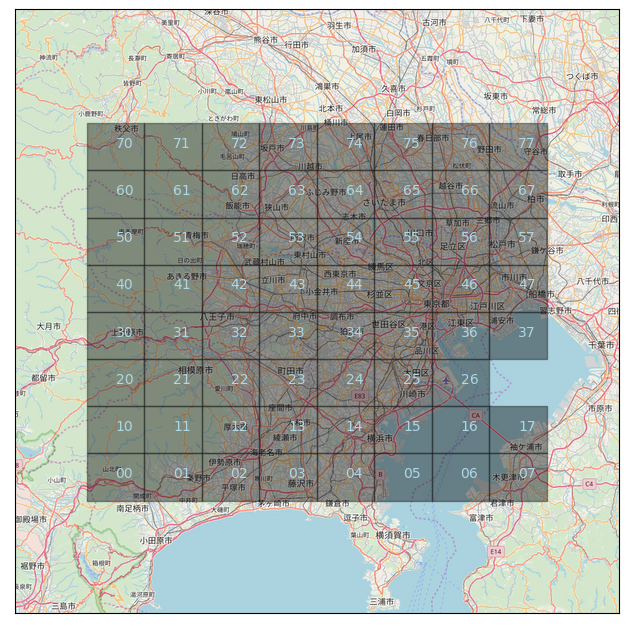

In [12]:
plot_on_map_with_text(mesh2.geometry, mesh2.index.str.slice(4, 6))

(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b2862d580>)

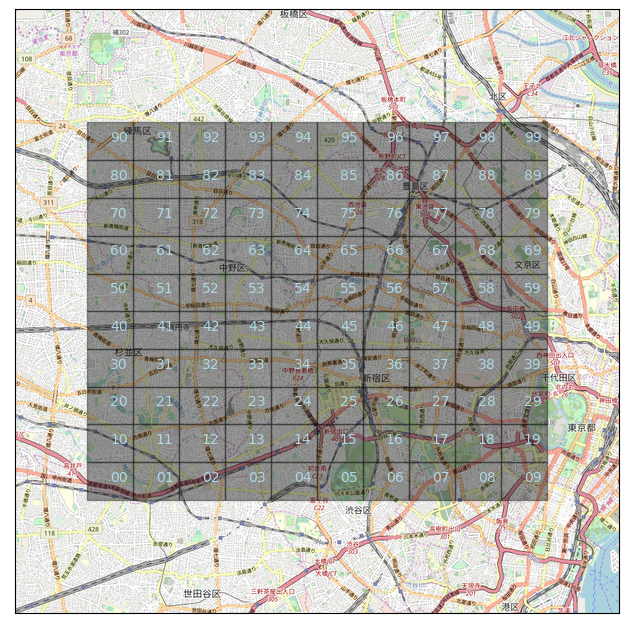

In [13]:
plot_on_map_with_text(mesh3.geometry, mesh3.index.str.slice(6, 8))

(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b286a72b0>)

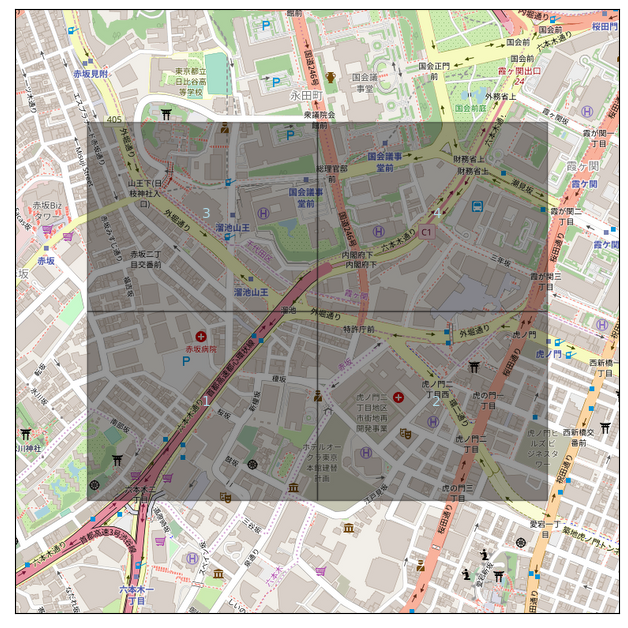

In [14]:
plot_on_map_with_text(mesh4.geometry, mesh4.index.str.slice(8, 9))

(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b287a3af0>)

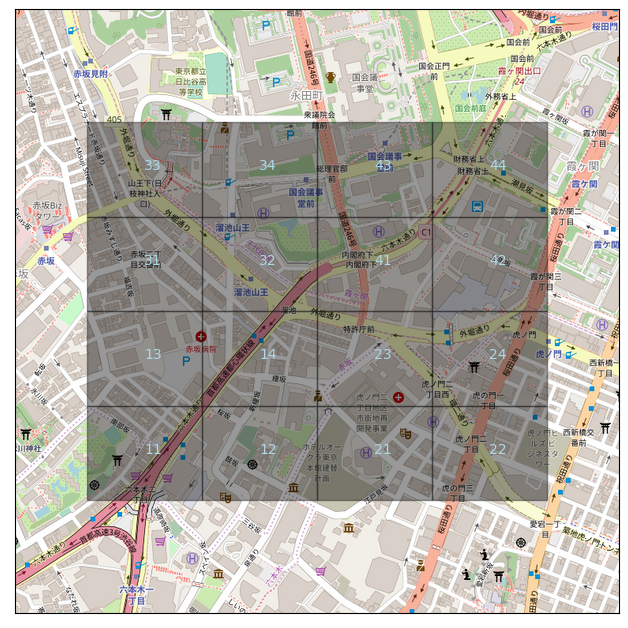

In [15]:
plot_on_map_with_text(mesh5.geometry, mesh5.index.str.slice(8, 10))